In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import seaborn as sns

# Data Exploration

In [ ]:
os.listdir("/content/drive/MyDrive/dataset")

['test', 'normal', 'train', 'pneumonia', 'validation', 'models']

In [ ]:
len(os.listdir("/content/drive/MyDrive/dataset/train/covid/"))

77

# Data Visualization

Train set:
COVID=77
NoCOVID=77
Test set:
COVID=18
NoCOVID=65
Validation set:
COVID=16
NoCOVID=64


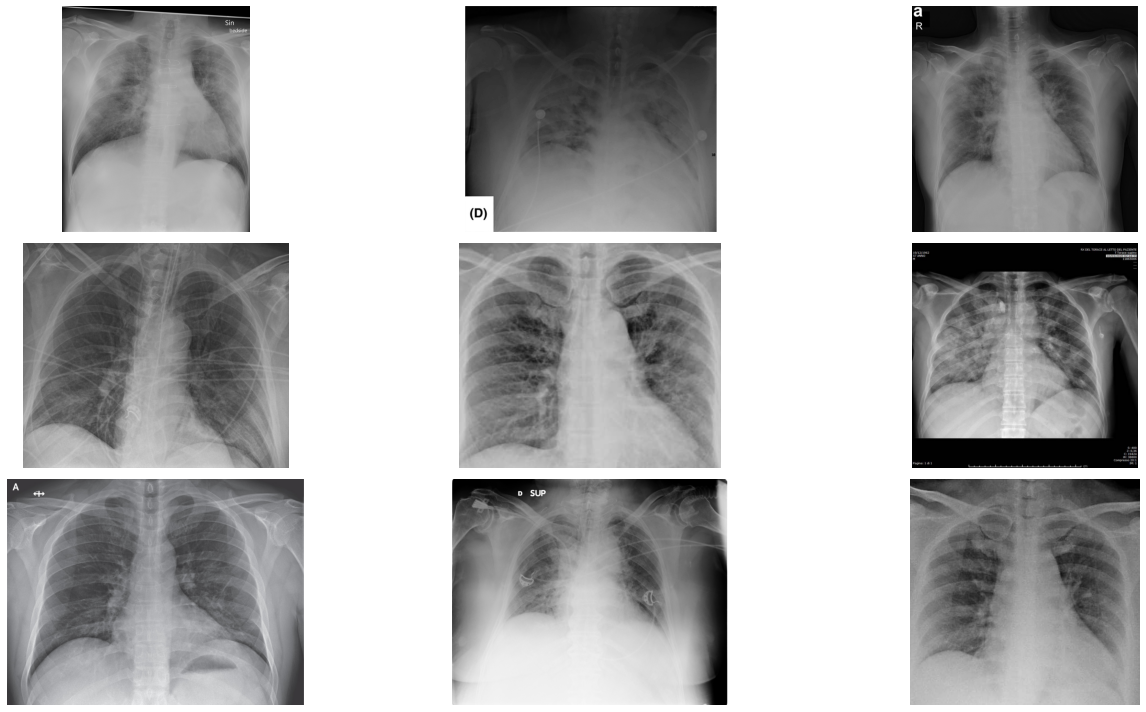

In [ ]:
train_dir = "/content/drive/MyDrive/dataset/train/"
test_dir = "/content/drive/MyDrive/dataset/test/"
val_dir = "/content/drive/MyDrive/dataset/validation/"

print("Train set:\n========================================")
num_covid = len(os.listdir(os.path.join(train_dir, 'covid')))
num_nocovid = len(os.listdir(os.path.join(train_dir, 'noCovid')))
print(f"COVID={num_covid}")
print(f"NoCOVID={num_nocovid}")

print("Test set:\n========================================")
print(f"COVID={len(os.listdir(os.path.join(test_dir, 'covid')))}")
print(f"NoCOVID={len(os.listdir(os.path.join(test_dir, 'noCovid')))}")

print("Validation set:\n========================================")
print(f"COVID={len(os.listdir(os.path.join(val_dir, 'covid')))}")
print(f"NoCOVID={len(os.listdir(os.path.join(val_dir, 'noCovid')))}")

covid = os.listdir("/content/drive/MyDrive/dataset/train/covid")
covid_dir = "/content/drive/MyDrive/dataset/train/covid"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(covid_dir, covid[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

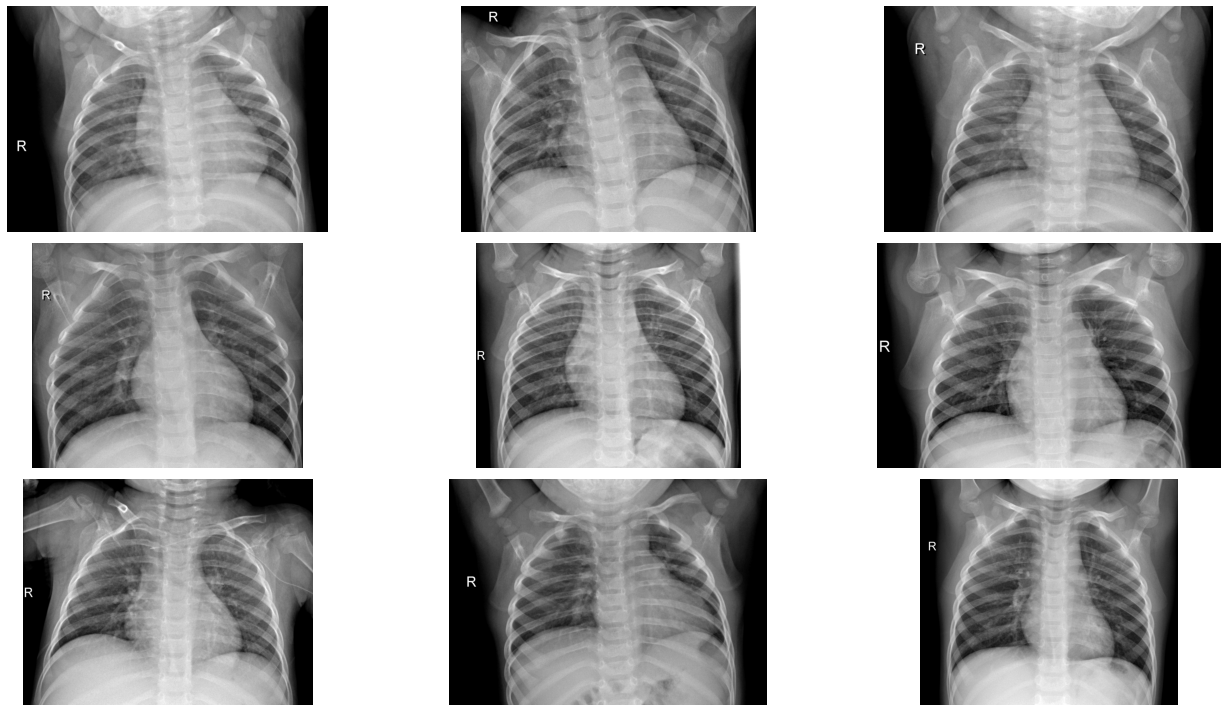

In [ ]:
normal = os.listdir("/content/drive/MyDrive/dataset/train/noCovid/")
normal_dir ="/content/drive/MyDrive/dataset/train/noCovid/"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

# Investigate a single image

The dimensions of the image are 1070 pixels width and 1520 pixels height, one single color channel.
The maximum pixel value is 255.0000 and the minimum is 0.0000
The mean value of the pixels is 118.6389 and the standard deviation is 70.1458


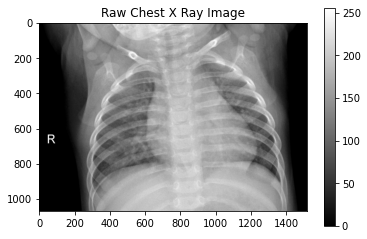

In [ ]:
normal_img = os.listdir("/content/drive/MyDrive/dataset/train/noCovid/")[0]
normal_dir = "/content/drive/MyDrive/dataset/train/noCovid/"
sample_img = plt.imread(os.path.join(normal_dir, normal_img))
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {sample_img.shape[0]} pixels width and {sample_img.shape[1]} pixels height, one single color channel.")
print(f"The maximum pixel value is {sample_img.max():.4f} and the minimum is {sample_img.min():.4f}")
print(f"The mean value of the pixels is {sample_img.mean():.4f} and the standard deviation is {sample_img.std():.4f}")

# Ivestigate pixel value distribution

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

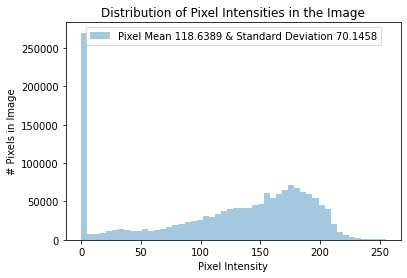

In [ ]:
sns.distplot(sample_img.ravel(),
            label=f"Pixel Mean {np.mean(sample_img):.4f} & Standard Deviation {np.std(sample_img):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [ ]:
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=8, 
                                                shuffle=True, 
                                                class_mode='binary',
                                                target_size=(320, 320))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(320, 320))

Found 154 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 320 pixels width and 320 pixels height, one single color channel.
The maximum pixel value is 2.3520 and the minimum is -3.9129
The mean value of the pixels is -0.0000 and the standard deviation is 1.0000


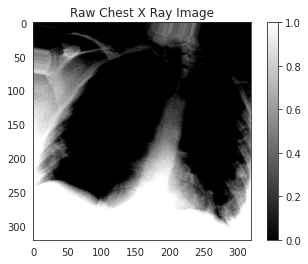

In [ ]:
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# Pixels in Image')

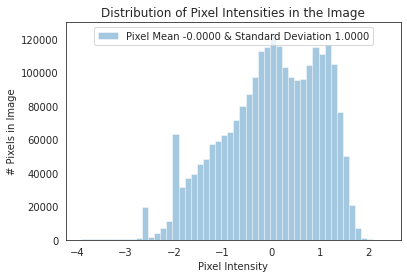

In [ ]:
sns.distplot(generated_image.ravel(),
            label=f"Pixel Mean {np.mean(generated_image):.4f} & Standard Deviation {np.std(generated_image):.4f}", kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
# Class weights

weight_for_0 = num_covid / (num_nocovid + num_covid)
weight_for_1 = num_nocovid / (num_nocovid + num_covid)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.50
Weight for class 1: 0.50


# Model Building

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(320, 320, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 318, 318, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 318, 318, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 316, 316, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 316, 316, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 158, 158, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 156, 156, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 156, 156, 64)      2

In [ ]:
r = model.fit(train, 
              epochs=1000, 
              validation_data=validation, 
              class_weight=class_weight)

Epoch 1/1000
20/20 [==============================] - 12s 575ms/step - loss: 0.1509 - accuracy: 0.8961 - val_loss: 0.2521 - val_accuracy: 0.9125
Epoch 2/1000
20/20 [==============================] - 11s 542ms/step - loss: 0.1542 - accuracy: 0.8896 - val_loss: 0.3083 - val_accuracy: 0.9250
Epoch 3/1000
20/20 [==============================] - 11s 540ms/step - loss: 0.1113 - accuracy: 0.9221 - val_loss: 0.2132 - val_accuracy: 0.9125
Epoch 4/1000
20/20 [==============================] - 11s 541ms/step - loss: 0.1132 - accuracy: 0.9286 - val_loss: 0.1333 - val_accuracy: 0.9375
Epoch 5/1000
20/20 [==============================] - 11s 543ms/step - loss: 0.0996 - accuracy: 0.9091 - val_loss: 0.1771 - val_accuracy: 0.9375
Epoch 6/1000
20/20 [==============================] - 11s 566ms/step - loss: 0.1432 - accuracy: 0.8961 - val_loss: 0.2169 - val_accuracy: 0.8875
Epoch 7/1000
20/20 [==============================] - 11s 542ms/step - loss: 0.1474 - accuracy: 0.8636 - val_loss: 0.2007 - val_ac

Text(0.5, 1.0, 'Accuracy Evolution')

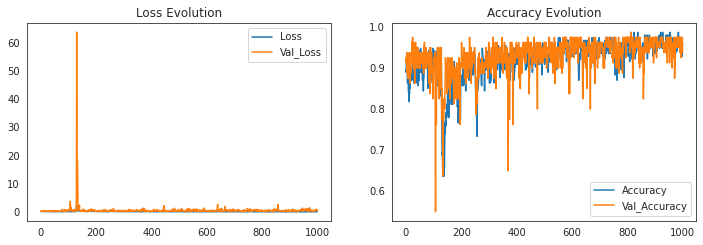

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

11/11 [==============================] - 23s 2s/step - loss: 0.0465 - accuracy: 0.9880
Test Accuracy: 98.80%
20/20 [==============================] - 7s 359ms/step - loss: 0.1220 - accuracy: 0.9740
Train Accuracy: 97.40%


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
pred = model.predict(test)

print(confusion_matrix(test.classes, pred > 0.5))
pd.DataFrame(classification_report(test.classes, pred > 0.5, output_dict=True))

[[ 3 15]
 [16 49]]


,0,1,accuracy,macro avg,weighted avg
precision,0.157895,0.765625,0.626506,0.461760,0.633828
recall,0.166667,0.753846,0.626506,0.460256,0.626506
f1-score,0.162162,0.759690,0.626506,0.460926,0.630106
support,18.000000,65.000000,0.626506,83.000000,83.000000


In [ ]:
print(confusion_matrix(test.classes, pred > 0.7))
pd.DataFrame(classification_report(test.classes, pred > 0.7, output_dict=True))

[[ 3 15]
 [17 48]]


,0,1,accuracy,macro avg,weighted avg
precision,0.150000,0.761905,0.614458,0.455952,0.629203
recall,0.166667,0.738462,0.614458,0.452564,0.614458
f1-score,0.157895,0.750000,0.614458,0.453947,0.621592
support,18.000000,65.000000,0.614458,83.000000,83.000000
